<a href="https://colab.research.google.com/github/showmeinfinity/final_project/blob/main/Step_2_calculating_diasgreement_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note that this notebook is run using Google Colab

In [ ]:
!pip install krippendorff
!pip install python-igraph leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import krippendorff
from scipy.stats import entropy
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
import leidenalg
import igraph as ig
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
# Set the random seed for reproducibility
np.random.seed(13)

Import all datasets

In [ ]:
offensiveness_popquorn = pd.read_csv('offensiveness_popquorn_cleaned.csv')
md_agreement = pd.read_csv('md_agreement_cleaned.csv')
offensiveness_popquorn_subset = pd.read_csv('high_sd_offensiveness_popquorn.csv')
md_agreement_subset = pd.read_csv('high_sd_md_agreement.csv')

# Step 1: Calculating disagreement between raters

For the full dataset, Krippendorff's Alpha will be calculated and for the subsets, the adjacency matrix will be calculated.

- calculate_agreement_scores evaluates how well annotators agree with each other using Krippendorff's Alpha.
- calculate_adjacency_matrix quantifies the average difference in ratings between pairs of annotators.

In [ ]:
# Pivot the datasets to get one row per instance and one column per user
op_pivot_table = offensiveness_popquorn.pivot(index='instance_id', columns='user_id', values='offensiveness')
md_pivot_table = md_agreement.pivot(index='instance_id', columns='user_id', values='offensiveness')
md_subset_pivot_table = md_agreement_subset.pivot(index='instance_id', columns='user_id', values='offensiveness')
op_subset_pivot_table = offensiveness_popquorn_subset.pivot(index='instance_id', columns='user_id', values='offensiveness')

In [ ]:
def calculate_agreement_scores(pivoted_data):
    """Calculate agreement scores."""
    # Initialise an empty matrix to hold the agreement scores
    agreement_matrix = np.zeros((pivoted_data.shape[1], pivoted_data.shape[1]))

    # Loop over pairs of annotators
    for i in range(pivoted_data.shape[1]):
        for j in range(i+1, pivoted_data.shape[1]):
            # Get the scores for the pair of annotators, excluding instances where either did not score
            pair_data = pivoted_data.iloc[:,[i,j]].dropna()

            # Check if all the ratings are the same
            if pair_data.nunique().max() <= 1:
                # If all the ratings are the same, set the agreement score to 1
                alpha = 1.0
            else:
                try:
                    # Otherwise, calculate Krippendorff's Alpha for the pair
                    alpha = krippendorff.alpha(pair_data.transpose().values, level_of_measurement='ordinal')
                except ZeroDivisionError:
                    print(f"Krippendorff's alpha calculation failed for user pair ({i},{j}). Setting agreement to zero.")
                    alpha = 0.0

            # Add the agreement score to the matrix
            agreement_matrix[i,j] = alpha
            agreement_matrix[j,i] = alpha

    # Create a DataFrame from the agreement matrix, with annotator IDs as the row and column labels
    agreement_df = pd.DataFrame(agreement_matrix, index=pivoted_data.columns, columns=pivoted_data.columns)
    print("Agreement Scores Calculated\n")

    return agreement_df

In [ ]:
# Calculate agreement scores
md_agreement_df = calculate_agreement_scores(md_pivot_table)
op_agreement_df = calculate_agreement_scores(op_pivot_table)

Agreement Scores Calculated

Agreement Scores Calculated



In [ ]:
md_agreement_df.to_csv("md_agreement_krippendorff.csv", index=False)
op_agreement_df.to_csv("op_agreement_krippendorff.csv", index=False)

In [ ]:
def calculate_adjacency_matrix(pivoted_data):
    """Calculate average absolute difference between pairs of annotators."""

    # Initialise an empty matrix to hold the agreement scores
    adjacency_matrix = np.zeros((pivoted_data.shape[1], pivoted_data.shape[1]))

    # Loop over pairs of annotators
    for i in range(pivoted_data.shape[1]):
        for j in range(i+1, pivoted_data.shape[1]):
            # Get the scores for the pair of annotators, excluding instances where either did not score
            pair_data = pivoted_data.iloc[:,[i,j]].dropna()

            # Calculate the absolute differences between the ratings
            differences = np.abs(pair_data.iloc[:, 0] - pair_data.iloc[:, 1])

            # Calculate the average difference
            avg_difference = differences.mean()

            # Add the average difference to the matrix
            adjacency_matrix[i,j] = avg_difference
            adjacency_matrix[j,i] = avg_difference

    # Create a DataFrame from the adjacency matrix, with annotator IDs as the row and column labels
    adjacency_df = pd.DataFrame(adjacency_matrix, index=pivoted_data.columns, columns=pivoted_data.columns)
    print("Adjacency Matrix Calculated\n")

    return adjacency_df

In [ ]:
# Calculate the adjacency matrix
md_subset_agreement = calculate_adjacency_matrix(md_subset_pivot_table)
op_subset_agreement = calculate_adjacency_matrix(op_subset_pivot_table)

Adjacency Matrix Calculated

Adjacency Matrix Calculated



In [ ]:
md_subset_agreement.to_csv("md_subset_agreement.csv", index=False)
op_subset_agreement.to_csv("op_subset_agreement.csv", index=False)

In [ ]:
def plot_agreement_heatmap(agreement_df):
    """
    Plots a heatmap based on the agreement between annotators.
    """
    plt.figure(figsize=(20, 15))
    sns.heatmap(agreement_df, cmap='coolwarm', center=0)
    plt.title('Annotator Agreement Heatmap', fontsize=20)
    plt.xlabel('Annotator 1', fontsize=15)
    plt.ylabel('Annotator 2', fontsize=15)
    plt.show()

### MD Agreement full dataset

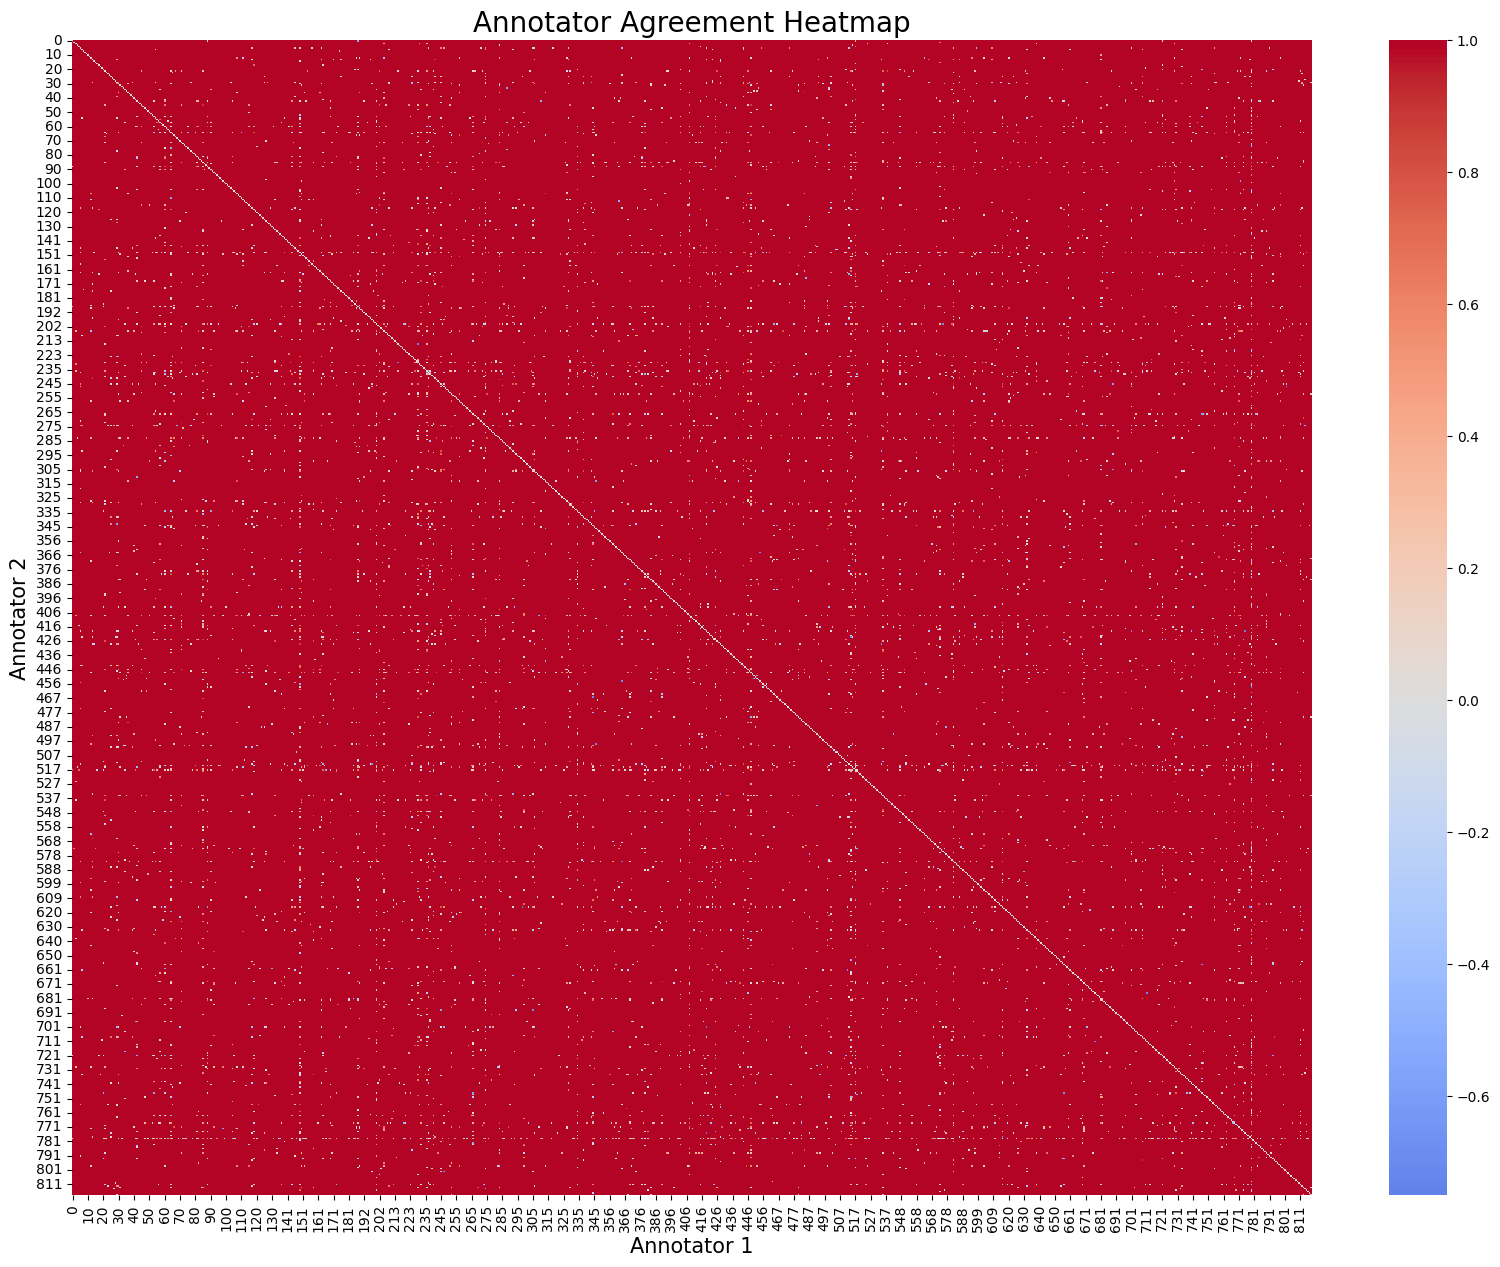

In [ ]:
plot_agreement_heatmap(md_agreement_df)

### MD Agreement subset

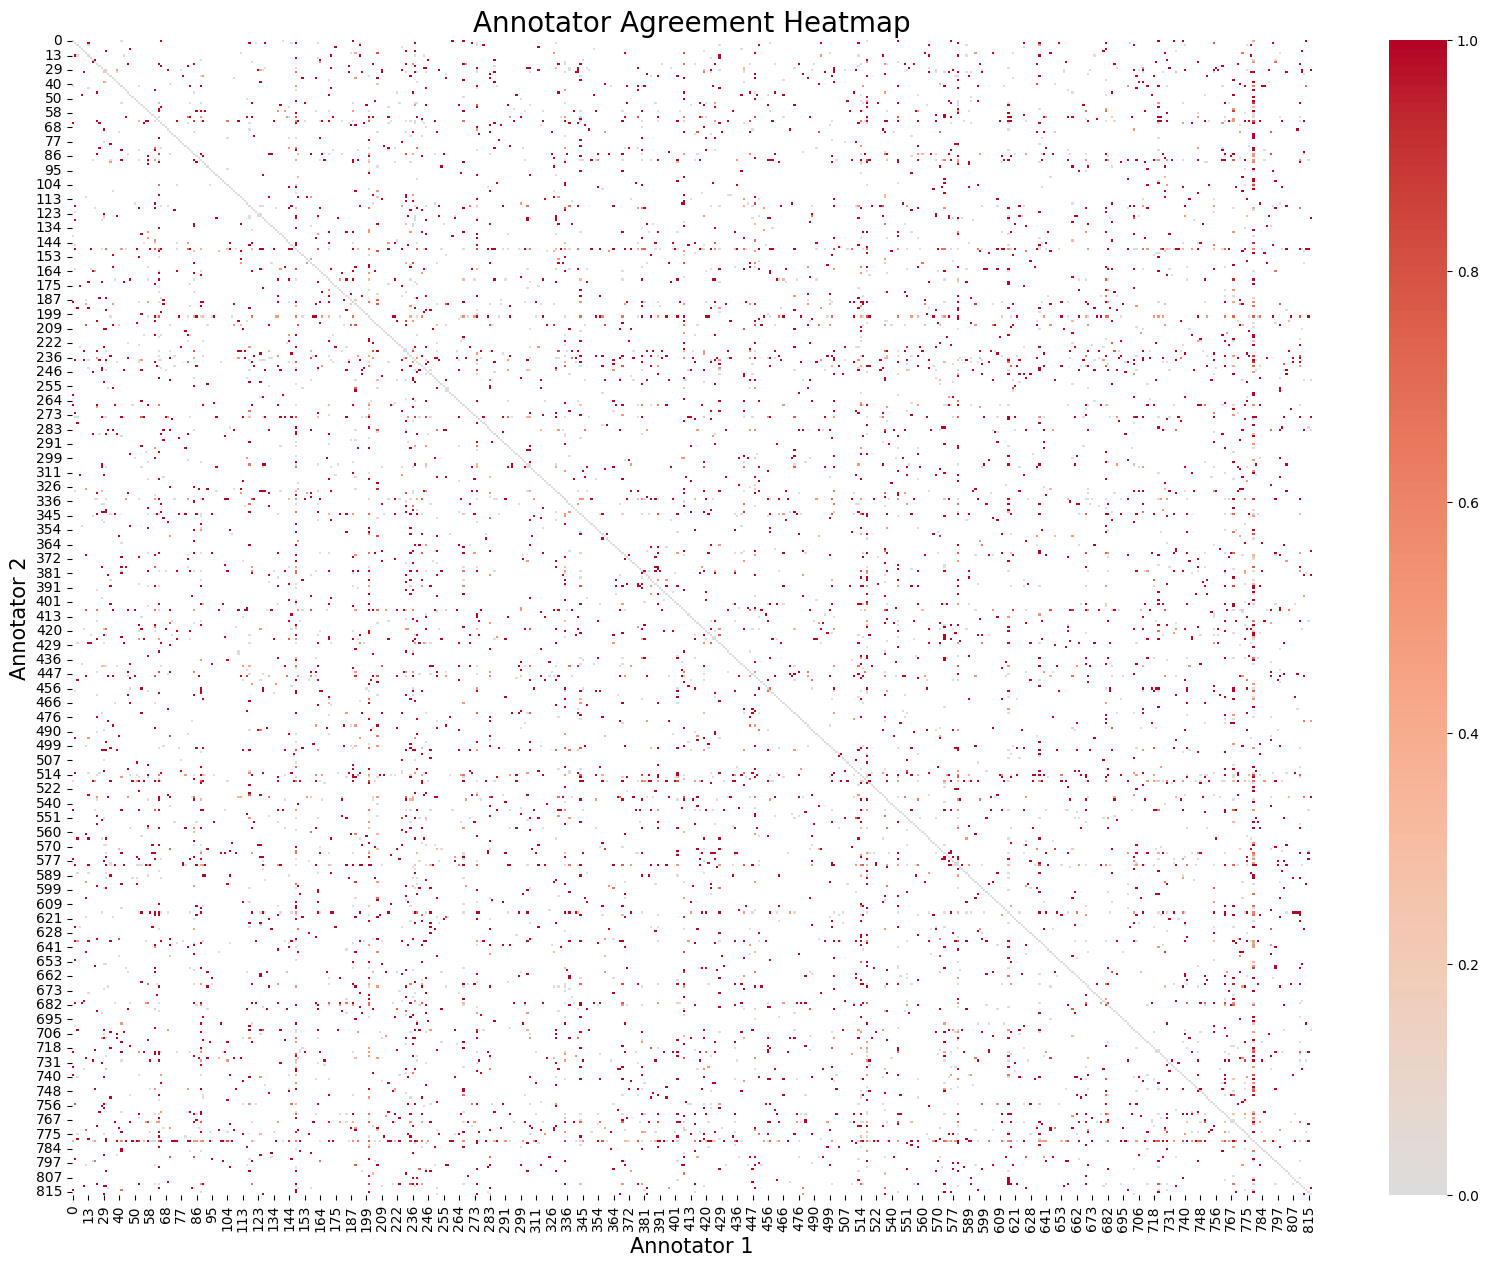

In [ ]:
plot_agreement_heatmap(md_subset_agreement)

### Offensiveness Popquorn full dataset

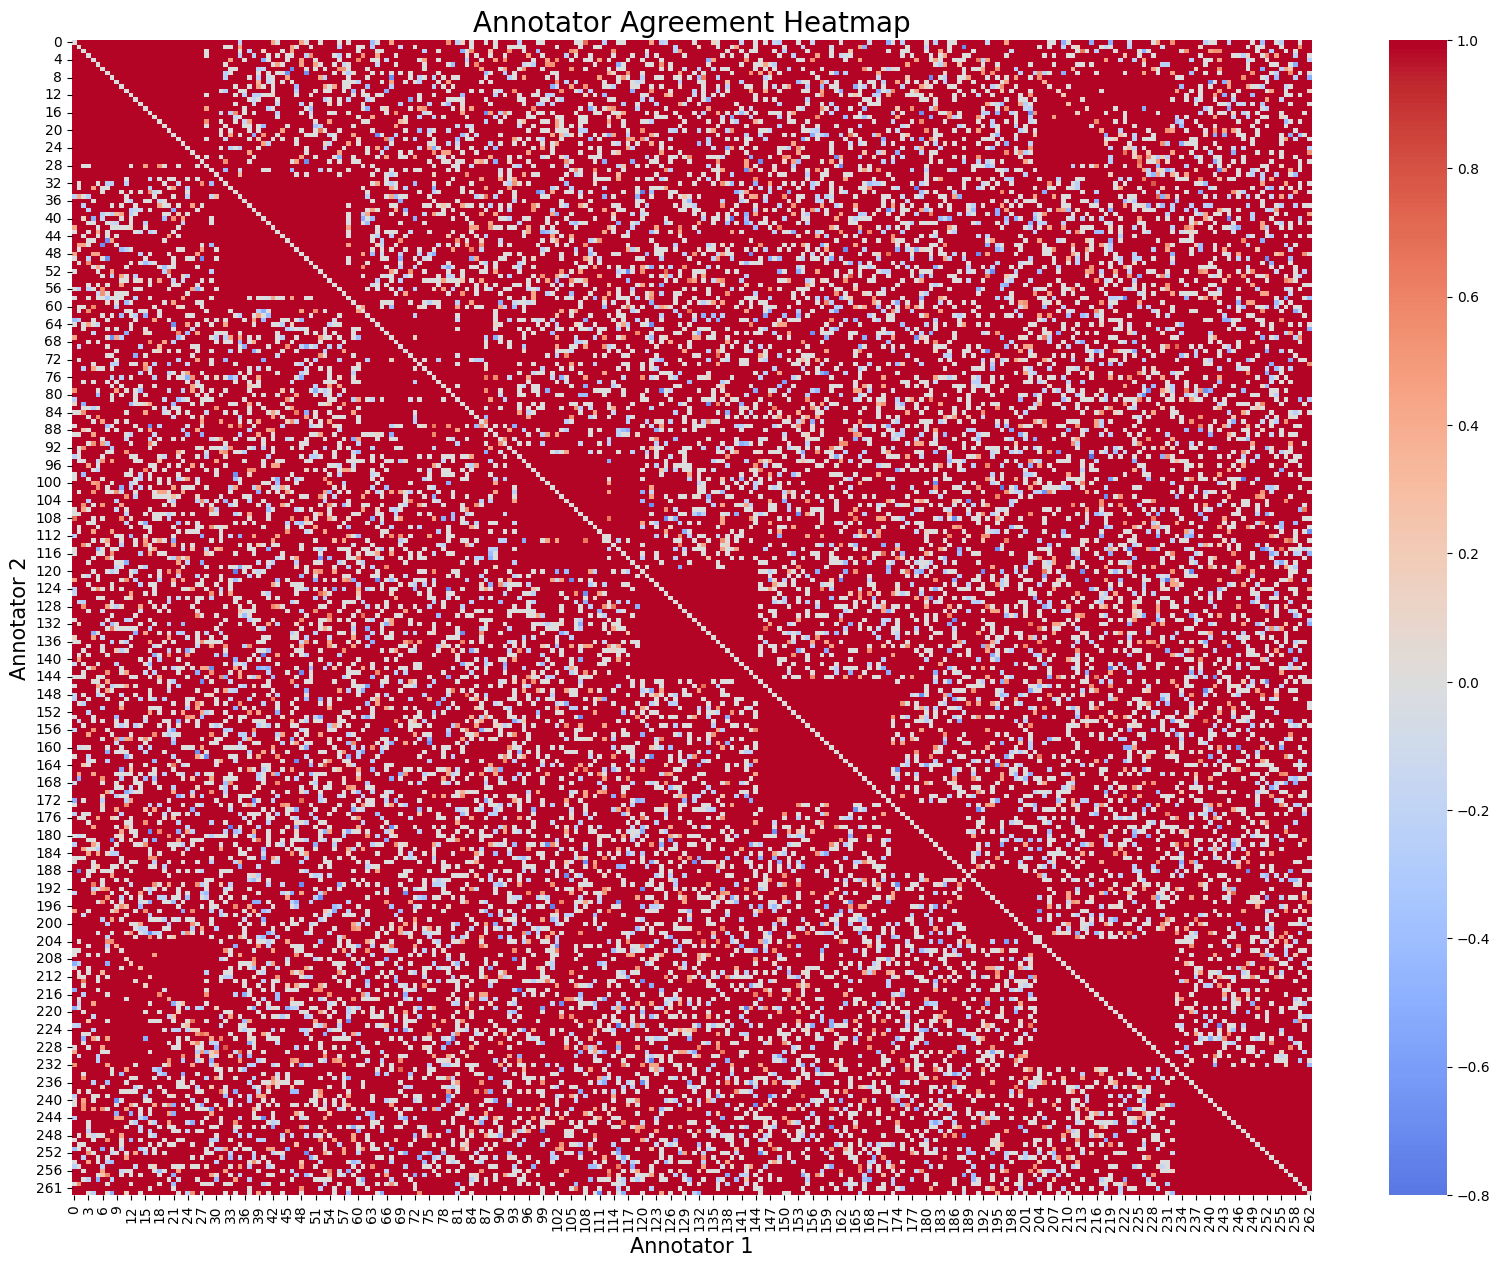

In [ ]:
plot_agreement_heatmap(op_agreement_df)

### Offensiveness Popquorn subset

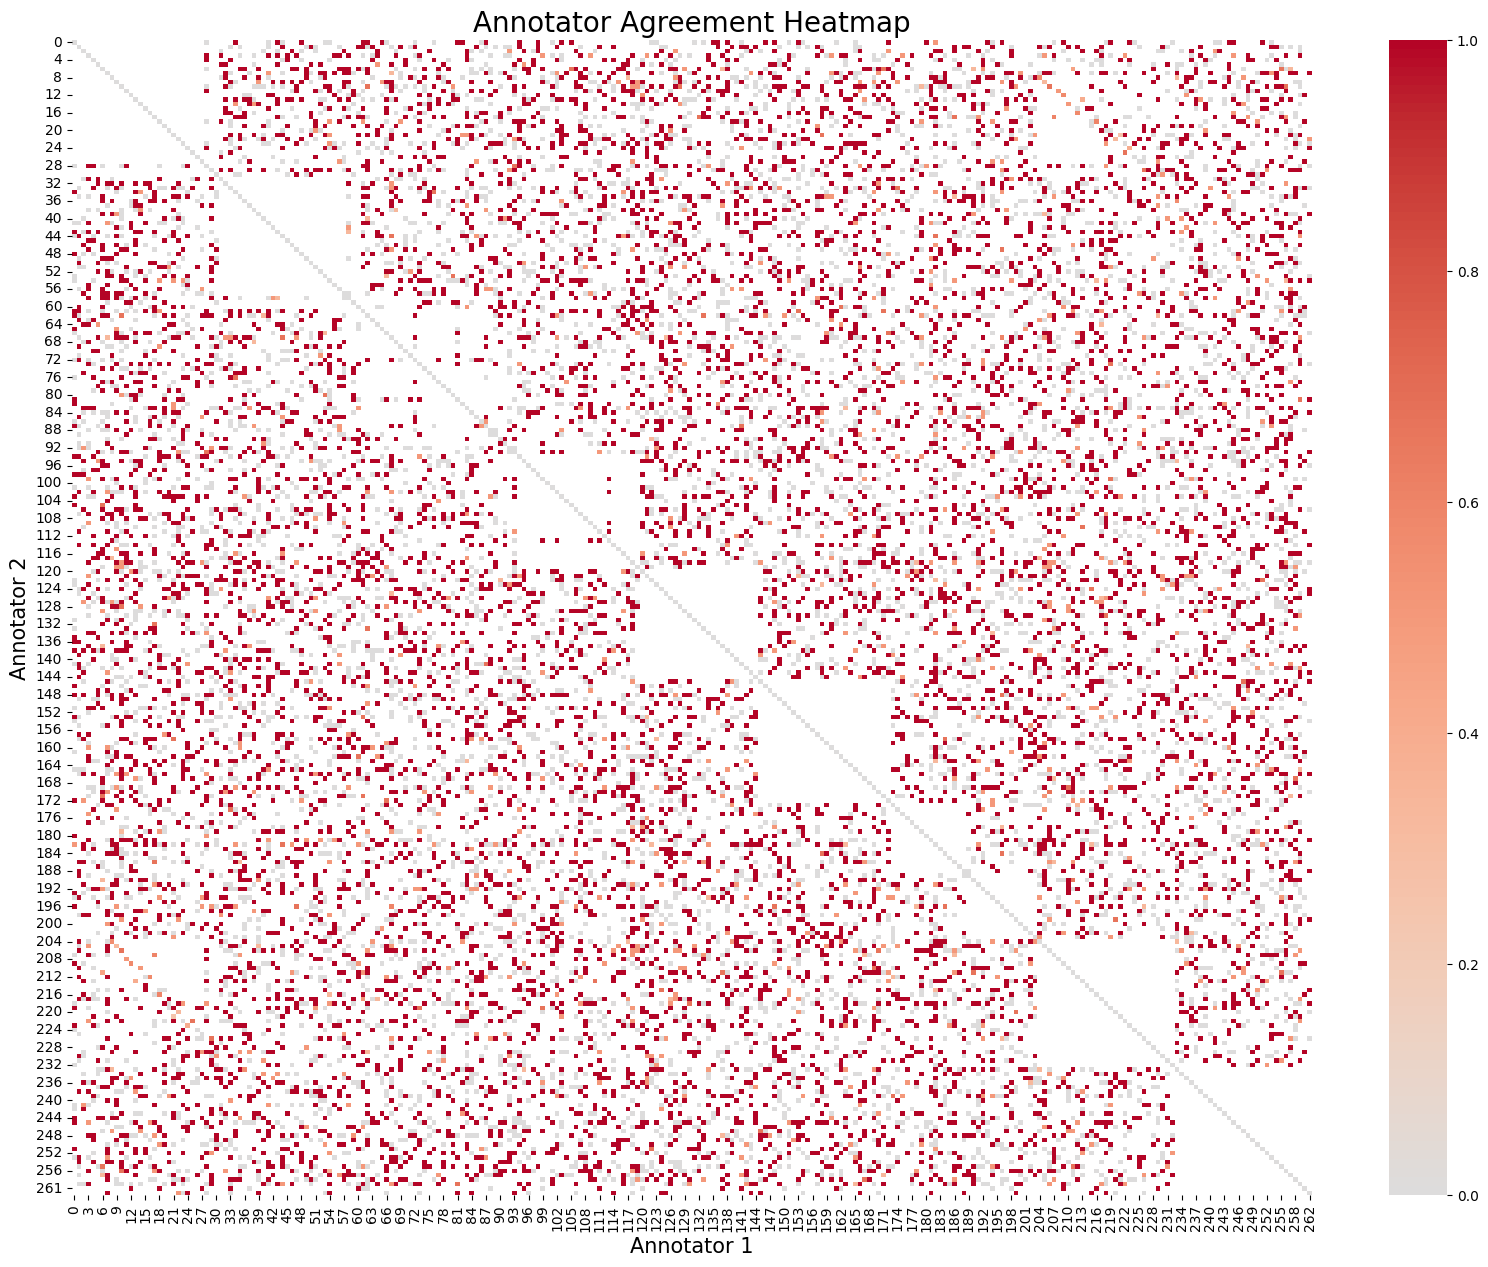

In [ ]:
plot_agreement_heatmap(op_subset_agreement)

# Step 2: Building graphs for all datasets

**`visualise_annotator_disagreement` Function Overview**

The `visualise_annotator_disagreement` function visualises the disagreements between annotators using a graph. The function can optionally incorporate demographic information (like 'race' and 'gender') as node attributes.

1. **Graph Initialisation**:
   - A new empty graph, `G`, is created.

2. **Edge Creation**:
   - For each pair of annotators, if their disagreement score (from the `agreement_df`) is negative (indicating disagreement), an edge is added between them. The weight of this edge represents the magnitude of their disagreement.

3. **Adding Node Attributes (Optional)**:
   - If a `demographics_df` is provided, the function adds 'race' and 'gender' as attributes to the nodes (annotators) present in both the graph and the demographics DataFrame.

4. **Isolated Node Removal**:
   - Nodes (annotators) without any edges (disagreements) are identified and removed from the graph.

5. **Layout Generation**:
   - A layout for the graph is generated using the `spring_layout` method. A fixed random seed (`seed=13`) ensures reproducibility of the layout across calls.

6. **Node Size Calculation**:
   - The size of each node in the visualization is determined based on the total disagreement of the respective annotator with others.

7. **Graph Visualization**:
   - Nodes are drawn with colors mapped to their total disagreement values. Darker nodes indicate higher disagreements.
   - Edges are drawn with colors and widths corresponding to the pairwise disagreement values. Darker and thicker edges indicate greater disagreements between the connected annotators.
   - Colorbars for nodes and edges are added to indicate the scale of disagreements.
   - The graph is displayed with a title and without axis markings.

In [ ]:
def visualise_annotator_disagreement(agreement_df, demographics_df=None):

    # Create a new graph
    G = nx.Graph()

    # Add edges with weight as disagreement
    for i, user_id1 in enumerate(agreement_df.columns):
        for j, user_id2 in enumerate(agreement_df.columns):
            if j > i and agreement_df.iloc[i, j] < 0:  # only consider lower triangle and negative values
                G.add_edge(user_id1, user_id2, weight=-agreement_df.iloc[i, j])  # use negative score to get disagreement

    # If demographic information is provided, add 'race' and 'gender' as node attributes
    if demographics_df is not None:
        for _, row in demographics_df.iterrows():
            user_id = row['user_id']
            if G.has_node(user_id):
                for attr in ['race', 'gender']:
                    if attr in demographics_df.columns:
                        G.nodes[user_id][attr] = row[attr]

    # Remove nodes without any edges (disagreements)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    # Generate layout
    layout = nx.kamada_kawai_layout(G)

    # Compute total disagreement per annotator for color and size mapping
    total_disagreement = pd.Series({user_id: sum(G[user_id][v]['weight'] for v in G[user_id]) for user_id in G.nodes()})

    # Draw the graph
    plt.figure(figsize=(15, 15))

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, layout, node_color=total_disagreement,
                                   cmap=plt.cm.Oranges, node_size=total_disagreement*200, alpha=0.8)

    # Draw edges
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    edges = nx.draw_networkx_edges(G, layout,
                                   edge_color=edge_colors,
                                   edge_cmap=plt.cm.Blues,
                                   width=[G[u][v]['weight']*2 for u, v in G.edges()])  # scale width for visibility

    plt.title('Filtered Network of Annotator Disagreements', size=15)
    plt.colorbar(nodes, label='Total Disagreement')
    plt.colorbar(edges, label='Pairwise Disagreement', cmap=plt.cm.Blues)
    plt.axis('off')
    plt.show()

    return G

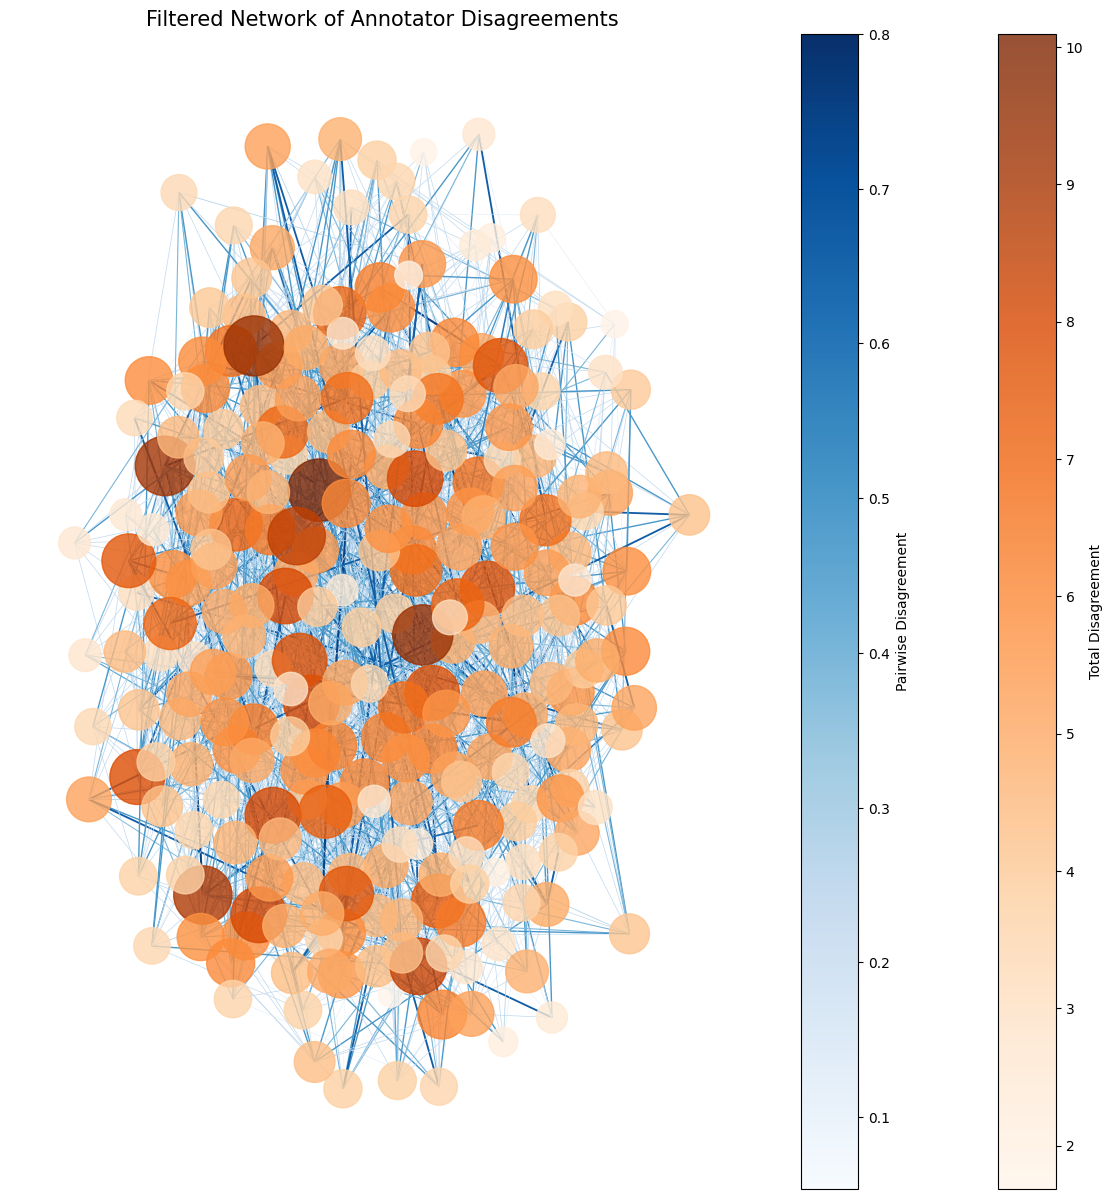

In [ ]:
# Visualise the graph for the op_agreement_df
G_op = visualise_annotator_disagreement(op_agreement_df, demographics_df=offensiveness_popquorn)

Note to think about: Should gender and race be visualised here too? Compare with demographic information. keep the scales the same for all networks. for mdagreement - check disagreement based on the topics.

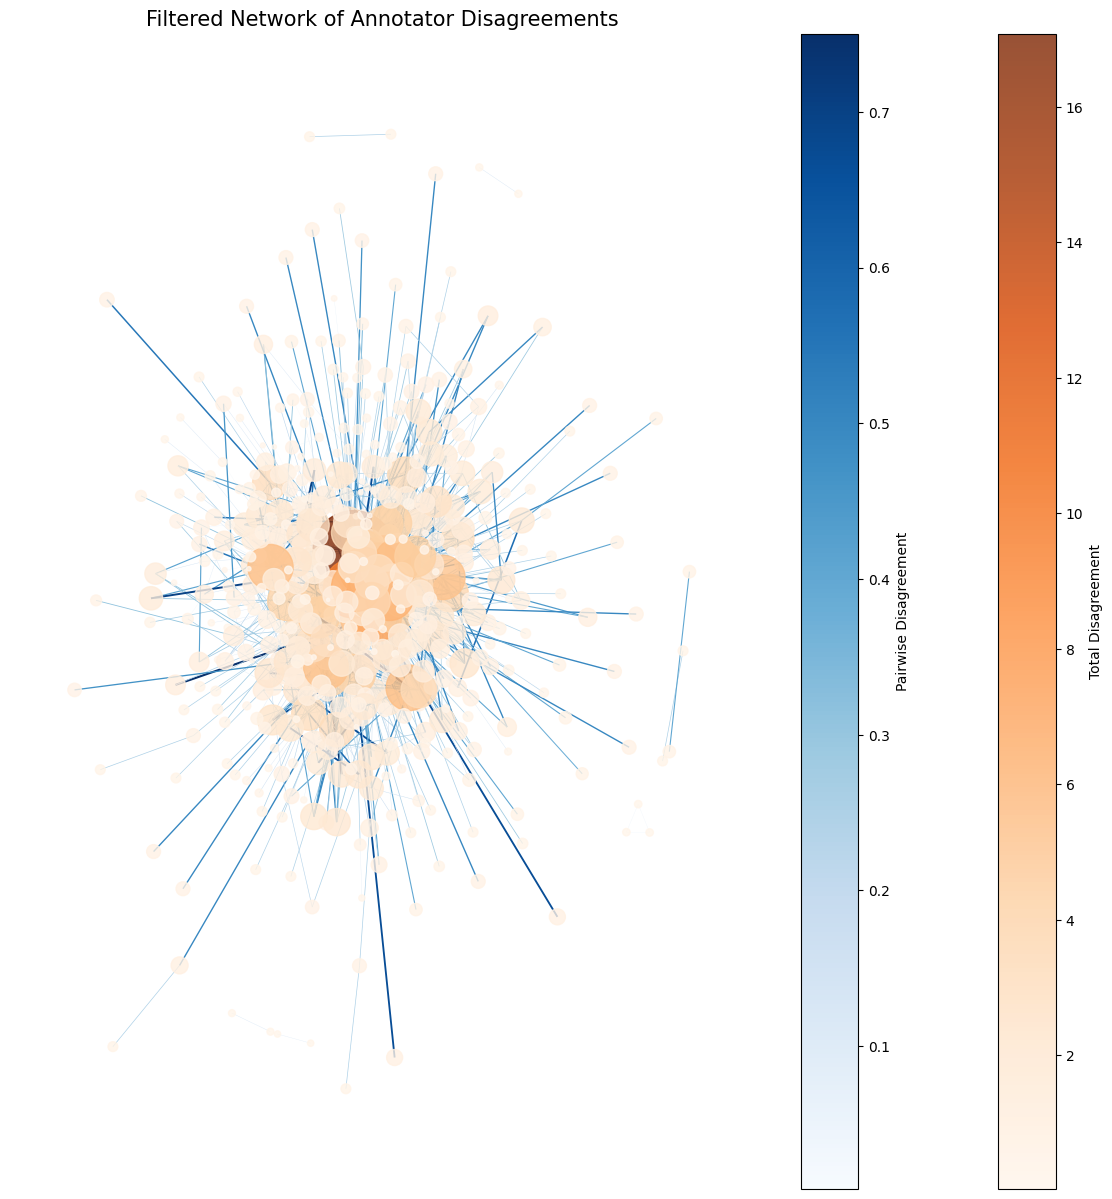

In [ ]:
G_md = visualise_annotator_disagreement(md_agreement_df)

In [ ]:
def subset_visualise_annotator_disagreement(agreement_df, demographics_df=None):

    # Create a new graph
    G = nx.Graph()

    # Add edges with weight as disagreement
    for i, user_id1 in enumerate(agreement_df.columns):
        for j, user_id2 in enumerate(agreement_df.columns):
            weight = agreement_df.iloc[i, j]
            if j > i and weight != 0:  # only consider lower triangle and nonzero disagreements
                G.add_edge(user_id1, user_id2, weight=weight)

    # If demographic information is provided, add 'race' and 'gender' as node attributes
    if demographics_df is not None:
        for _, row in demographics_df.iterrows():
            user_id = row['user_id']
            if G.has_node(user_id):
                for attr in ['race', 'gender']:
                    if attr in demographics_df.columns:
                        G.nodes[user_id][attr] = row[attr]

    # Generate layout using spring_layout
    layout = nx.kamada_kawai_layout(G)

    # Compute total disagreement per annotator for color and size mapping
    total_disagreement = pd.Series({user_id: np.mean([G[user_id][v]['weight'] for v in G[user_id]]) for user_id in G.nodes()})

    # Draw the graph
    plt.figure(figsize=(15, 15))

    # Draw nodes with specified color map and size scaling
    nodes = nx.draw_networkx_nodes(G, layout, node_color=total_disagreement,
                                   cmap=plt.cm.Oranges, node_size=total_disagreement*200, alpha=0.8)

    # Draw edges with specified color map and width scaling
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    edges = nx.draw_networkx_edges(G, layout,
                                   edge_color=edge_colors,
                                   edge_cmap=plt.cm.Blues,
                                   width=[G[u][v]['weight']*2 for u, v in G.edges()])  # scale width for visibility

    # Title
    plt.title('Filtered Network of Annotator Disagreements', size=15)
    plt.colorbar(nodes, label='Average Disagreement')
    plt.colorbar(edges, label='Pairwise Disagreement', cmap=plt.cm.Blues)
    plt.axis('off')
    plt.show()

    return G


# Replace NaN values with zeros
op_subset_agreement = op_subset_agreement.fillna(0)
md_subset_agreement = md_subset_agreement.fillna(0)

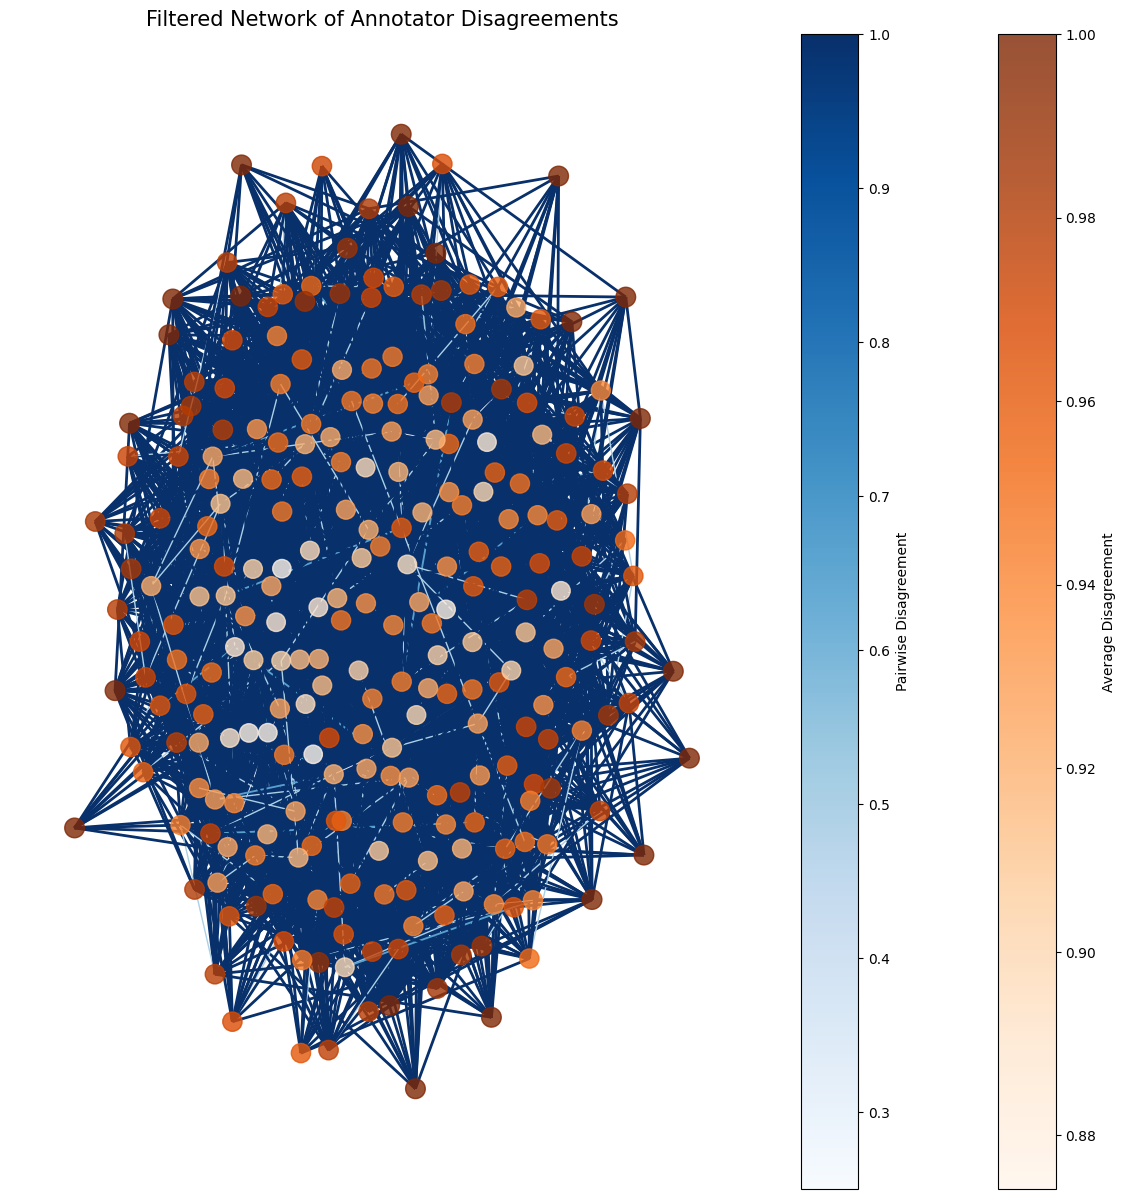

In [ ]:
G_op_subset = subset_visualise_annotator_disagreement(op_subset_agreement, demographics_df=offensiveness_popquorn)

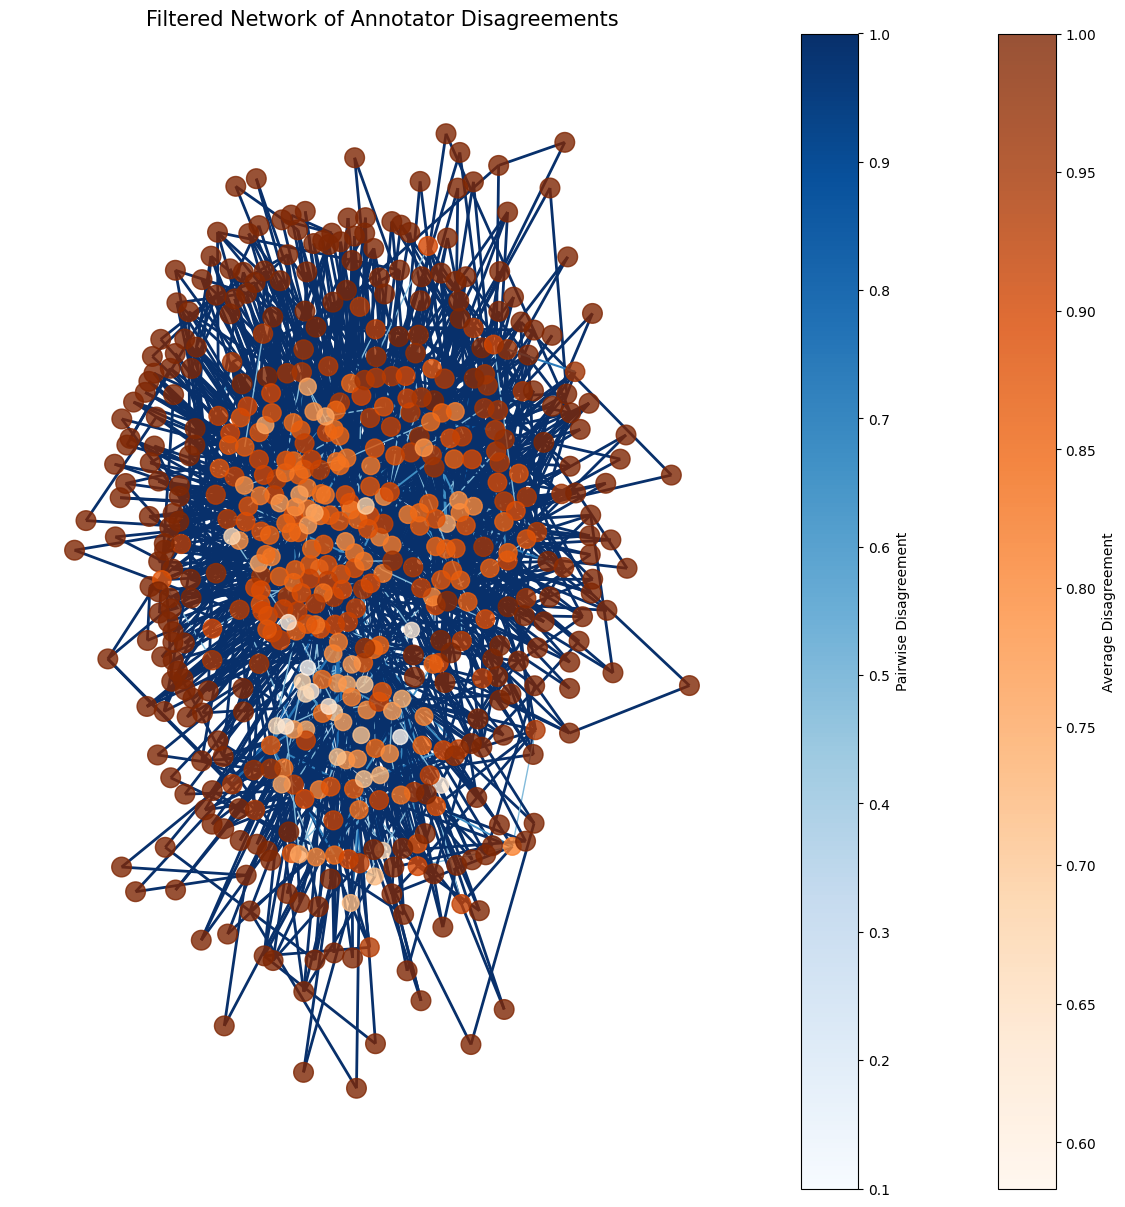

In [ ]:
G_md_subset = subset_visualise_annotator_disagreement(md_subset_agreement)

# Step 3: Community detection algorithms

In [ ]:
def compute_conductance(G, partition):

    conductances = {}

    # Invert the partition dictionary to map communities to nodes
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    for community, nodes in communities.items():
        # Edges within the community
        internal_edges = G.subgraph(nodes).number_of_edges()

        # Edges leaving the community
        external_edges = sum(1 for node in nodes for neighbor in G.neighbors(node) if neighbor not in nodes)

        # Compute conductance
        conductance = external_edges / (2 * internal_edges + external_edges)
        conductances[community] = conductance

    return conductances

In [ ]:
def compute_conductance(G, partition):
    """
    Compute the conductance for each community in the partition.

    Parameters:
    - G: the graph
    - partition: a dictionary mapping nodes to communities

    Returns:
    - conductances: a dictionary mapping communities to their conductance values
    """
    conductances = {}

    # Invert the partition dictionary to map communities to nodes
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    for community, nodes in communities.items():
        # Edges within the community
        internal_edges = G.subgraph(nodes).number_of_edges()

        # Edges leaving the community
        external_edges = sum(1 for node in nodes for neighbor in G.neighbors(node) if neighbor not in nodes)

        # Compute conductance
        conductance = external_edges / (2 * internal_edges + external_edges)
        conductances[community] = conductance

    return conductances

## Louvain Algorithm

In [ ]:
def detect_communities_louvain(G):
    """Detect communities and visualize the graph."""
    # Compute the best partition using the Louvain method
    partition = community_louvain.best_partition(G)

    # Create a figure of size 8x8 inches
    plt.figure(figsize=(8, 8))

    # Create a dictionary that maps community numbers to different colors
    colors = {community: color for community, color in enumerate(set(partition.values()))}

    # Draw the nodes, with node color indicating community
    nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_size=100, cmap=plt.cm.jet, node_color=[colors[partition[node]] for node in G.nodes])

    # Draw the edges
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G), alpha=0.5)

    # Show the plot
    plt.show()

    return partition

In [ ]:
def print_communities_louvain(partition):
    """Print out the communities."""
    # Create an empty dictionary for communities
    communities = {}

    # Loop through each node and their assigned community in the partition
    for node, community in partition.items():
        # If the community is not in the dictionary, add it with the node
        if community not in communities:
            communities[community] = [node]
        # If the community is already in the dictionary, append the node to it
        else:
            communities[community].append(node)

    # Print out the communities
    for community, nodes in communities.items():
        print(f"Community {community}: {nodes}")

    return communities

### Offensiveness Popquorn full dataset

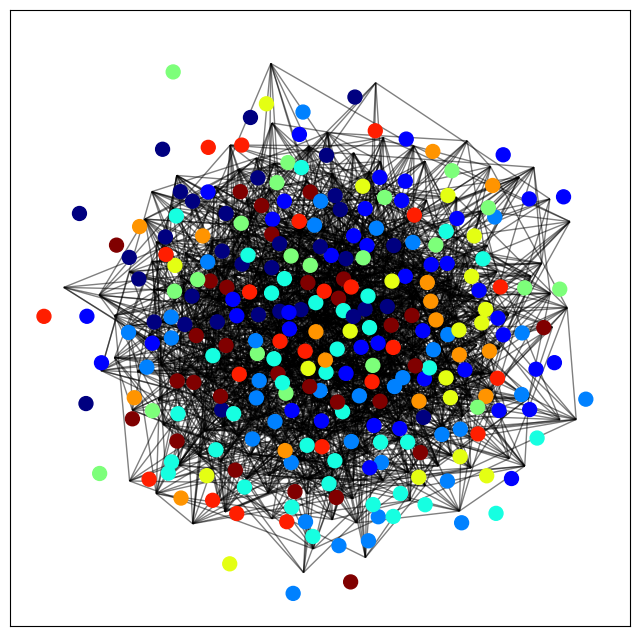

Community 0: [0, 81, 94, 141, 209, 215, 219, 223, 251, 56, 3, 121, 247, 262, 115, 129, 7, 45, 91, 161, 200, 205, 41, 60, 191, 48, 99, 143, 142, 65, 26, 111, 261, 250]
Community 1: [35, 148, 1, 154, 160, 167, 188, 74, 49, 83, 248, 146, 184, 252, 119, 128, 159, 171, 10, 62, 101, 114, 138, 158, 109, 14, 75, 123, 196, 201, 246, 15, 133, 179, 84, 187, 85, 145, 257, 22, 72, 27, 206, 42, 96]
Community 2: [63, 125, 175, 127, 218, 2, 82, 226, 152, 134, 5, 80, 97, 183, 135, 203, 254, 170, 9, 240, 243, 155, 165, 59, 90, 12, 249, 103, 116, 108, 174, 88, 25, 235, 30, 228, 78]
Community 3: [112, 149, 244, 230, 37, 150, 104, 4, 40, 192, 236, 39, 199, 120, 102, 194, 234, 131, 36, 13, 71, 237, 137, 139, 186, 233, 19, 52, 157, 77, 229, 130, 189, 185, 213, 204, 220]
Community 4: [124, 182, 239, 57, 231, 32, 92, 136, 100, 122, 79, 51, 147, 241, 29, 232, 242, 144, 105, 55, 214]
Community 6: [156, 66, 224, 64, 95, 106, 153, 245, 21, 54, 68, 113, 117, 259, 212, 86]
Community 7: [168, 255, 198, 162, 163, 258,

In [ ]:
# Detect communities
partition_op_louvain = detect_communities_louvain(G_op)

communities_op_louvain = print_communities_louvain(partition_op_louvain)

modularity_op_louvain = community_louvain.modularity(partition_op_louvain, G_op)
print(f"Modularity (Louvain): {modularity_op_louvain}")

conductances = compute_conductance(G_op, partition_op_louvain)
average_conductance_op_louvain = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Louvain): {average_conductance_op_louvain}")

### Offensiveness Popquorn subset

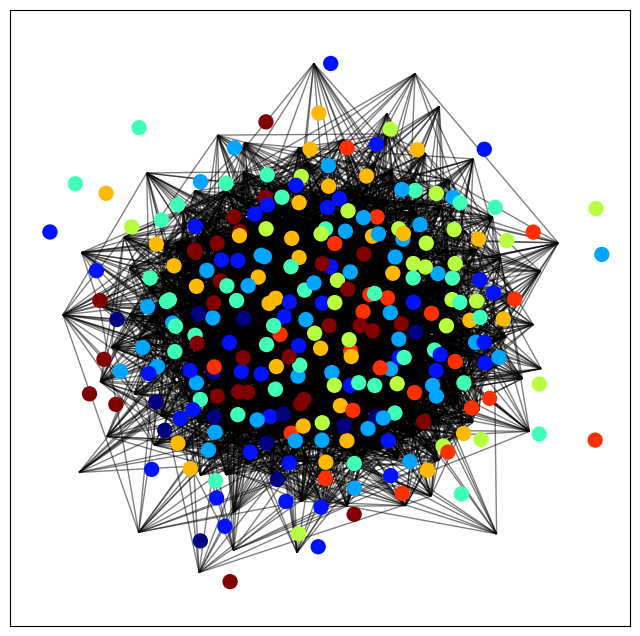

Community 1: [0, 34, 61, 82, 135, 136, 193, 209, 223, 111, 210, 230, 253, 106, 124, 236, 242, 55, 134, 151, 163, 33, 76, 52, 176, 77, 108, 190, 104, 8, 71, 149, 247, 88, 169, 54, 11, 208, 37, 14, 178, 246, 15, 24, 25]
Community 2: [43, 94, 219, 245, 1, 50, 60, 141, 144, 157, 189, 212, 217, 254, 64, 83, 158, 198, 3, 41, 68, 73, 109, 123, 126, 175, 222, 259, 174, 5, 120, 150, 187, 195, 145, 128, 165, 243, 38, 16, 90, 232, 20, 21, 227]
Community 3: [48, 138, 172, 182, 244, 63, 114, 238, 2, 46, 75, 92, 166, 183, 191, 213, 241, 28, 160, 205, 4, 97, 32, 79, 132, 255, 252, 229, 9, 42, 84, 119, 86, 89, 13, 201, 23, 156, 224, 27, 110, 100]
Community 4: [62, 105, 72, 85, 186, 57, 58, 118, 137, 177, 207, 248, 70, 192, 116, 6, 35, 49, 129, 168, 171, 211, 228, 257, 226, 258, 133, 17, 29]
Community 5: [65, 81, 98, 188, 204, 127, 162, 112, 117, 140, 249, 147, 36, 74, 7, 91, 155, 184, 197, 200, 233, 240, 80, 185, 234, 59, 202, 12, 225, 19, 40, 152, 130]
Community 6: [87, 153, 69, 139, 194, 95, 216, 31

In [ ]:
# Detect communities
partition_op_subset_louvain = detect_communities_louvain(G_op_subset)

communities_op_subset_louvain = print_communities_louvain(partition_op_subset_louvain)

modularity_op_subset_louvain = community_louvain.modularity(partition_op_subset_louvain, G_op_subset)
print(f"Modularity (Louvain): {modularity_op_subset_louvain}")

conductances = compute_conductance(G_op_subset, partition_op_subset_louvain)
average_conductance_op_subset_louvain = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Louvain): {average_conductance_op_subset_louvain}")

### MD Agreement full dataset

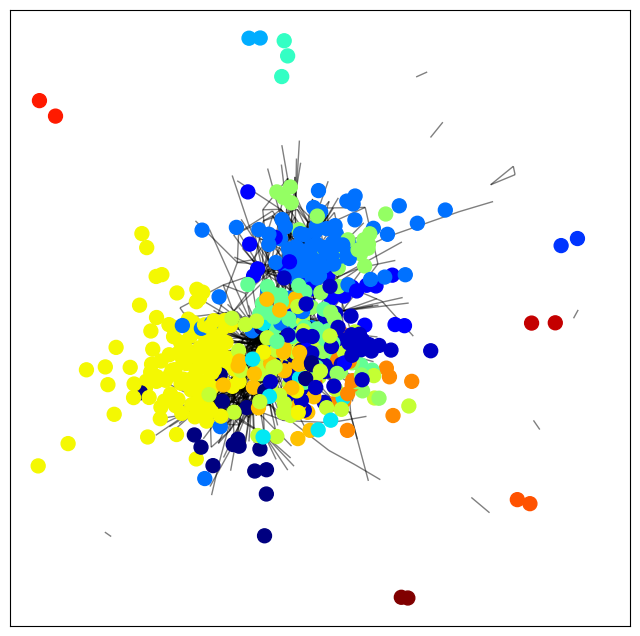

Community 10: [0, 188, 20, 747, 793, 64, 515, 42, 53, 82, 310, 610, 656, 697, 721, 784, 47, 438, 546, 763, 379, 75, 110, 150, 165, 295, 461, 538, 569, 601, 619, 669, 739, 105, 266, 358, 511, 522, 682, 192, 296, 213, 782, 369, 568, 704, 360, 365, 583, 420, 435, 591, 521, 588, 655, 675, 737]
Community 1: [779, 32, 41, 425, 62, 104, 377, 723, 741, 774, 65, 74, 120, 78, 81, 510, 753, 112, 362, 730, 135, 152, 719, 194, 220, 693, 479, 262, 286, 443, 311, 350, 381, 555, 459, 713, 463, 809, 471, 574, 524, 541, 578, 641, 712, 785, 799]
Community 2: [5, 149, 364, 598, 13, 163, 582, 22, 755, 43, 52, 293, 685, 176, 456, 648, 735, 743, 169, 203, 800, 386, 631, 454, 366, 397, 564, 664, 683]
Community 4: [237, 328, 513, 6, 632, 661, 708, 196, 25, 241, 553, 775, 29, 77, 225, 245, 343, 419, 447, 501, 566, 608, 615, 672, 701, 30, 197, 576, 39, 223, 371, 54, 138, 236, 70, 306, 623, 79, 270, 103, 113, 117, 146, 209, 338, 740, 123, 487, 125, 126, 277, 305, 129, 294, 786, 373, 451, 164, 512, 205, 171, 474, 

In [ ]:
partition_md_louvain = detect_communities_louvain(G_md)

communities_md_louvain = print_communities_louvain(partition_md_louvain)

modularity_md_louvain = community_louvain.modularity(partition_md_louvain, G_md)
print(f"Modularity (Louvain): {modularity_md_louvain}")

conductances = compute_conductance(G_md, partition_md_louvain)
average_conductance_md_louvain = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Louvain): {average_conductance_md_louvain}")

### MD-Agreement subset

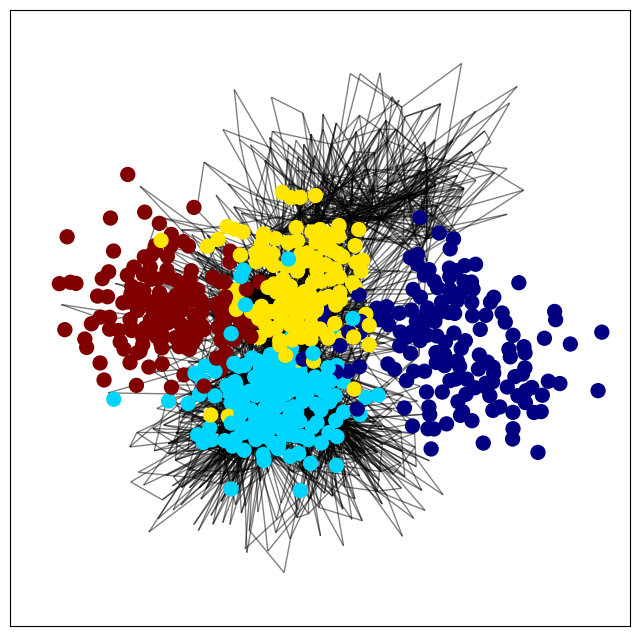

Community 1: [0, 65, 260, 546, 576, 721, 739, 779, 814, 149, 370, 14, 16, 20, 164, 246, 285, 730, 655, 719, 747, 793, 64, 425, 556, 811, 22, 81, 186, 760, 377, 42, 82, 88, 371, 381, 424, 573, 596, 697, 713, 774, 784, 785, 44, 60, 334, 49, 52, 205, 508, 53, 118, 153, 417, 526, 55, 58, 173, 212, 238, 418, 641, 656, 699, 723, 75, 104, 134, 461, 766, 799, 198, 743, 72, 276, 74, 420, 144, 372, 354, 166, 349, 436, 510, 613, 633, 732, 94, 99, 100, 102, 286, 376, 753, 105, 572, 769, 106, 109, 453, 135, 140, 389, 400, 415, 491, 282, 332, 401, 570, 815, 151, 601, 463, 591, 311, 223, 807, 696, 259, 291, 539, 301, 310, 345, 471, 520, 362, 378, 391, 627, 395, 746, 490, 430, 809, 502, 585, 673]
Community 2: [188, 266, 733, 582, 650, 681, 791, 10, 47, 517, 344, 34, 79, 90, 232, 390, 402, 500, 589, 704, 718, 751, 162, 37, 768, 515, 511, 169, 297, 351, 438, 449, 466, 715, 763, 56, 57, 86, 91, 136, 141, 340, 352, 379, 434, 509, 514, 557, 558, 669, 712, 200, 293, 619, 62, 240, 675, 165, 295, 317, 369, 60

In [ ]:
# Detect communities
partition_md_subset_louvain = detect_communities_louvain(G_md_subset)

communities_md_louvain = print_communities_louvain(partition_md_subset_louvain)

modularity_md_subset_louvain = community_louvain.modularity(partition_md_subset_louvain, G_md_subset)
print(f"Modularity (Louvain): {modularity_md_subset_louvain}")

conductances = compute_conductance(G_md_subset, partition_md_subset_louvain)
average_conductance_md_subset_louvain = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Louvain): {average_conductance_md_subset_louvain}")

## Leiden Algorithm

In [ ]:
def detect_communities_leiden(G):
    """Detect communities and visualize the graph."""
    # Convert the networkx graph to an igraph object
    ig_graph = ig.Graph.from_networkx(G)

    # Compute the best partition using the Leiden method
    partition_obj = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)

    # Use the original node order from NetworkX graph for mapping
    nodes_order = list(G.nodes())
    partition_dict = {nodes_order[node]: membership for node, membership in enumerate(partition_obj.membership)}

    # Create a figure of size 8x8 inches
    plt.figure(figsize=(8, 8))

    # Create a dictionary that maps community numbers to different colors
    colors = {community: color for community, color in enumerate(set(partition_dict.values()))}

    # Draw the nodes, with node color indicating community
    nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_size=100, cmap=plt.cm.jet, node_color=[colors[partition_dict[node]] for node in G.nodes()])

    # Draw the edges
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G), alpha=0.5)

    # Show the plot
    plt.show()

    return partition_dict, ig_graph, partition_obj

In [ ]:
def print_communities_leiden(partition):
    """Print out the communities."""
    # Create an empty dictionary for communities
    communities = {}

    # Loop through each node and their assigned community in the partition
    for node, community in partition.items():
        # If the community is not in the dictionary, add it with the node
        if community not in communities:
            communities[community] = [node]
        # If the community is already in the dictionary, append the node to it
        else:
            communities[community].append(node)

    # Print out the communities
    for community, nodes in communities.items():
        print(f"Community {community}: {nodes}")

    return communities

### MD Agreement full dataset

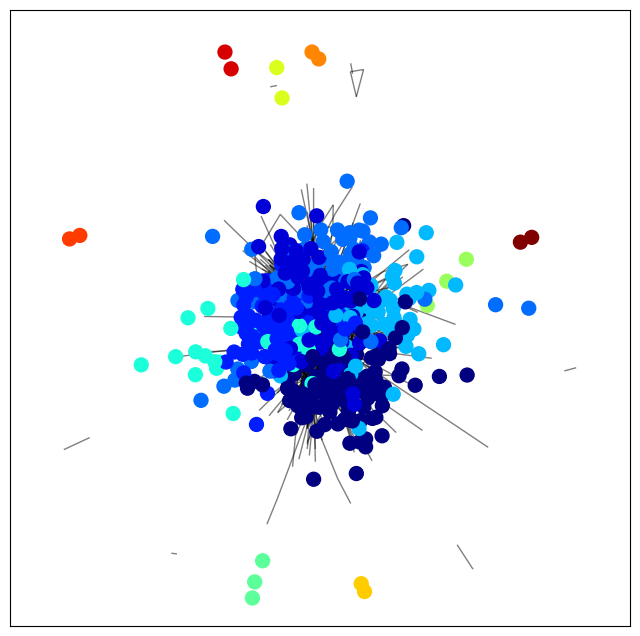

Community 1: [0, 779, 32, 33, 288, 500, 34, 718, 751, 41, 610, 768, 56, 57, 90, 136, 273, 344, 589, 200, 293, 514, 62, 240, 402, 558, 619, 681, 741, 750, 65, 73, 74, 120, 76, 78, 453, 86, 105, 783, 135, 210, 464, 147, 504, 505, 181, 185, 358, 194, 219, 297, 352, 466, 477, 498, 575, 653, 752, 815, 220, 232, 693, 386, 390, 777, 262, 782, 422, 302, 311, 337, 581, 357, 369, 767, 817, 350, 761, 354, 568, 704, 366, 384, 397, 555, 523, 678, 463, 809, 471, 482, 715, 509, 574, 609, 622, 662, 710, 726, 524, 561, 578, 630, 641, 712, 785, 799]
Community 2: [188, 16, 517, 20, 747, 793, 64, 515, 811, 616, 576, 425, 42, 53, 82, 310, 656, 697, 721, 784, 47, 438, 223, 371, 546, 763, 88, 60, 238, 334, 345, 379, 417, 573, 75, 104, 144, 165, 295, 377, 415, 461, 601, 669, 723, 774, 81, 491, 249, 418, 510, 739, 753, 109, 112, 362, 118, 266, 518, 730, 212, 389, 456, 205, 166, 173, 511, 522, 192, 760, 213, 285, 479, 748, 286, 424, 570, 596, 657, 360, 365, 381, 400, 401, 420, 459, 713, 564, 591, 732, 521, 588,

In [ ]:
# Detect communities
partition_md_leiden, ig_graph_md_leiden, partition_obj_md_leiden = detect_communities_leiden(G_md)

communities_md_leiden = print_communities_leiden(partition_md_leiden)

# Calculate modularity using leidenalg's quality method
modularity_md_leiden = partition_obj_md_leiden.quality()
print(f"Modularity (Leiden): {modularity_md_leiden}")

conductances = compute_conductance(G_md, partition_md_leiden)
average_conductance_md_leiden = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Leiden): {average_conductance_md_leiden}")

### MD-Agreement subset

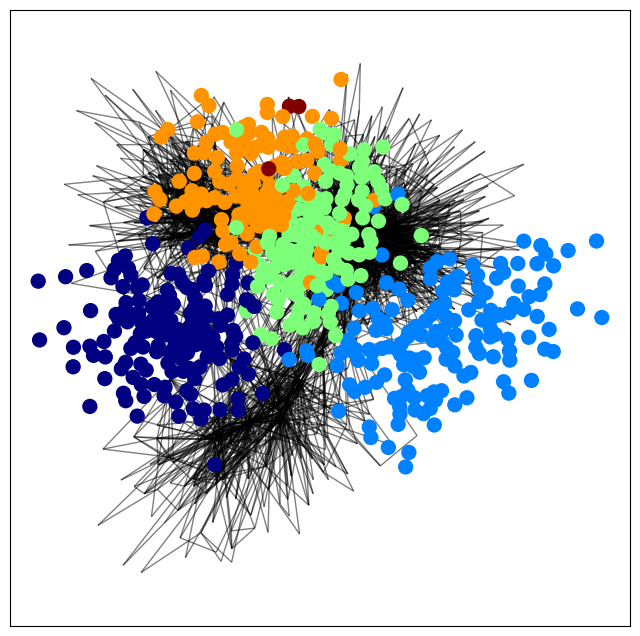

Community 2: [0, 65, 260, 546, 576, 721, 739, 779, 814, 149, 370, 16, 20, 164, 246, 285, 517, 730, 655, 719, 747, 793, 425, 556, 811, 22, 81, 186, 760, 377, 42, 82, 88, 371, 381, 424, 573, 596, 697, 713, 774, 784, 785, 44, 60, 334, 49, 52, 205, 508, 53, 118, 153, 417, 526, 55, 379, 58, 173, 212, 238, 418, 641, 656, 723, 75, 104, 134, 461, 766, 799, 743, 72, 276, 420, 144, 372, 354, 166, 349, 436, 510, 613, 633, 732, 94, 99, 100, 102, 286, 376, 753, 105, 572, 769, 109, 453, 135, 435, 140, 389, 400, 415, 491, 282, 332, 401, 570, 815, 151, 601, 591, 311, 223, 807, 696, 280, 291, 539, 301, 310, 345, 471, 520, 362, 391, 627, 395, 746, 490, 430, 585, 673]
Community 3: [188, 266, 733, 582, 681, 10, 47, 64, 344, 34, 79, 90, 232, 390, 402, 500, 589, 704, 718, 751, 162, 37, 768, 515, 511, 169, 297, 351, 438, 449, 466, 715, 763, 56, 57, 86, 91, 136, 340, 352, 434, 509, 514, 557, 558, 669, 712, 200, 293, 619, 699, 62, 240, 675, 165, 295, 317, 369, 609, 750, 777, 783, 74, 120, 76, 288, 581, 80, 210

In [ ]:
# Detect communities
partition_md_subset_leiden, ig_graph_md_subset_leiden, partition_obj_md_subset_leiden = detect_communities_leiden(G_md_subset)

communities_md_subset_leiden = print_communities_leiden(partition_md_subset_leiden)

# Calculate modularity using leidenalg's quality method
modularity_md_subset_leiden = partition_obj_md_subset_leiden.quality()
print(f"Modularity (Leiden): {modularity_md_subset_leiden}")

conductances = compute_conductance(G_md_subset, partition_md_subset_leiden)
average_conductance_md_subset_leiden = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Leiden): {average_conductance_md_subset_leiden}")

### Offensiveness Popquorn full dataset

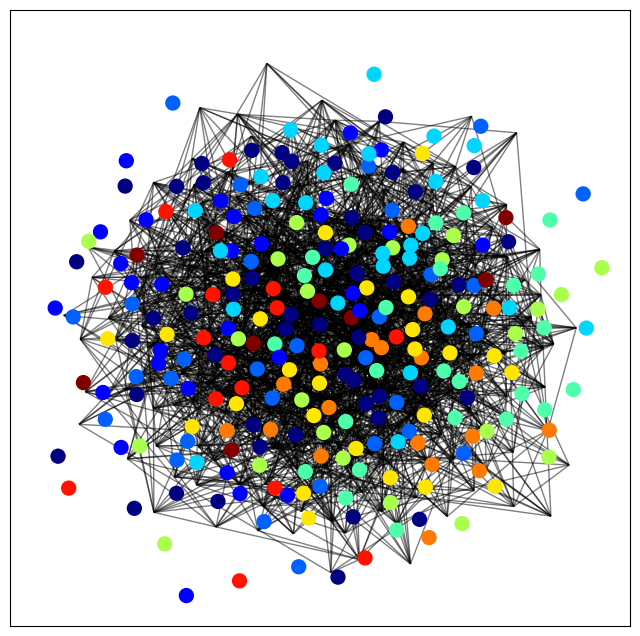

Community 8: [0, 124, 125, 175, 182, 193, 215, 218, 198, 163, 90, 103, 108, 93, 44, 55]
Community 7: [35, 112, 209, 219, 253, 73, 76, 243, 101, 12, 89, 169, 191, 116, 33, 145, 24, 27, 217]
Community 4: [63, 188, 98, 152, 40, 262, 132, 32, 8, 92, 136, 170, 184, 194, 11, 107, 131, 100, 133, 139, 233, 18, 229, 28, 212, 111]
Community 1: [81, 148, 149, 230, 150, 5, 64, 115, 183, 231, 200, 62, 102, 234, 59, 13, 71, 122, 245, 43, 246, 17, 186, 19, 166, 187, 23, 235, 210, 261, 207]
Community 0: [94, 172, 223, 244, 251, 1, 69, 154, 160, 180, 74, 49, 162, 247, 134, 95, 129, 7, 45, 91, 161, 254, 181, 60, 119, 153, 109, 14, 48, 99, 123, 201, 15, 143, 31, 51, 52, 84, 126, 113, 164, 197, 65, 29, 227, 208, 176, 189, 204, 250, 214]
Community 5: [141, 82, 4, 66, 83, 192, 221, 224, 236, 57, 80, 87, 203, 53, 195, 50, 16, 140, 21, 54, 85, 117, 142, 257, 259, 225]
Community 3: [156, 255, 56, 37, 3, 104, 121, 258, 248, 199, 146, 171, 36, 137, 22, 72, 177, 88, 26, 77, 211, 242, 228, 130, 190, 61, 86, 96]
Co

In [ ]:
# Detect communities
partition_op_leiden, ig_graph_op_leiden, partition_obj_op = detect_communities_leiden(G_op)

communities_op = print_communities_leiden(partition_op_leiden)

# Calculate modularity using leidenalg's quality method
modularity_op_leiden = partition_obj_op.quality()
print(f"Modularity (Leiden): {modularity_op_leiden}")

conductances = compute_conductance(G_op, partition_op_leiden)
average_conductance_op_leiden = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Leiden): {average_conductance_op_leiden}")

### Offensiveness Popquorn subset

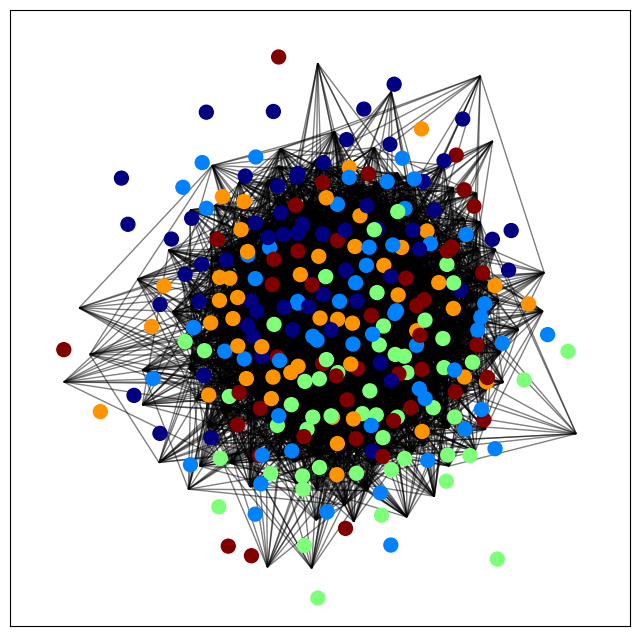

Community 3: [0, 34, 43, 81, 148, 182, 196, 209, 219, 245, 251, 60, 217, 238, 46, 64, 213, 241, 3, 45, 58, 68, 99, 126, 134, 162, 163, 222, 259, 76, 150, 122, 184, 218, 101, 185, 59, 86, 159, 13, 201, 90, 152, 23, 130, 25, 30, 110]
Community 1: [48, 65, 87, 193, 223, 1, 44, 72, 85, 114, 141, 157, 189, 210, 212, 253, 254, 124, 143, 198, 55, 73, 109, 175, 177, 205, 33, 174, 192, 67, 120, 49, 79, 96, 115, 170, 228, 257, 7, 91, 131, 161, 226, 240, 262, 128, 9, 165, 243, 225, 37, 125, 14, 38, 246, 24]
Community 2: [61, 62, 105, 146, 180, 50, 111, 142, 144, 186, 206, 57, 106, 127, 158, 166, 28, 41, 47, 118, 137, 160, 181, 207, 248, 256, 70, 93, 116, 6, 35, 39, 108, 129, 132, 167, 168, 171, 190, 211, 237, 255, 258, 119, 10, 80, 199, 234, 11, 89, 133, 208, 17]
Community 0: [82, 98, 103, 136, 138, 153, 244, 63, 188, 204, 2, 83, 95, 183, 236, 242, 31, 107, 121, 123, 4, 112, 117, 140, 221, 249, 5, 32, 147, 176, 187, 195, 36, 74, 77, 104, 155, 164, 200, 233, 8, 113, 229, 235, 42, 84, 88, 169, 202,

In [ ]:
# Detect communities
partition_op_subset_leiden, ig_graph_op_subset_leiden, partition_obj_op_subset_leiden = detect_communities_leiden(G_op_subset)

communities_op_subset_leiden = print_communities_leiden(partition_op_subset_leiden)

# Calculate modularity using leidenalg's quality method
modularity_op_subset_leiden = partition_obj_op_subset_leiden.quality()
print(f"Modularity (Leiden): {modularity_op_subset_leiden}")

conductances = compute_conductance(G_op_subset, partition_op_subset_leiden)
average_conductance_op_subset_leiden = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Leiden): {average_conductance_op_subset_leiden}")

## Spectral Clustering

**REDO ALL WITH CORRECT CLUSTER NUMBERS**

In [ ]:
def detect_communities_and_compute_modularity(G, n_clusters):
    """Detect communities using spectral clustering and compute modularity."""

    # Get the adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).toarray()

    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100)
    labels = sc.fit_predict(adjacency_matrix)

    # Create a dictionary that maps each node to its community label
    partition_dict = dict(zip(list(G.nodes()), labels))

    m = len(G.edges())
    a = {}
    e = {}

    # Compute the fraction of edges that fall inside each community
    for node, community in partition_dict.items():
        e[community] = e.get(community, 0) + sum(1 for neighbor in G.neighbors(node) if partition_dict[neighbor] == community)

    # Compute the fraction of edges that connect to each community
    for node, community in partition_dict.items():
        k = G.degree(node)
        a[community] = a.get(community, 0) + k

    # Modularity computation
    modularity = sum((e[community] / (2 * m)) - (a[community] / (2 * m)) ** 2 for community in set(partition_dict.values()))

    return modularity

def compute_modularity_multiple_k(G, k_range):
    """Compute modularity for a range of cluster numbers."""
    return {k: detect_communities_and_compute_modularity(G, k) for k in k_range}

In [ ]:
# Compute modularity for cluster numbers ranging from 2 to 10
k_range = range(2, 15)

modularity_values_md = compute_modularity_multiple_k(G_md, k_range)
modularity_values_op = compute_modularity_multiple_k(G_op, k_range)
modularity_values_md_subset = compute_modularity_multiple_k(G_md_subset, k_range)
modularity_values_op_subset = compute_modularity_multiple_k(G_op_subset, k_range)

print("G_md Modularity Values:", modularity_values_md)
print("G_op Modularity Values:", modularity_values_op)
print("G_md_subset Modularity Values:", modularity_values_md_subset)
print("G_op_subset Modularity Values:", modularity_values_op_subset)

G_md Modularity Values: {2: 0.005067534867980957, 3: 0.008440155696925918, 4: 0.010122164299116516, 5: 0.010126466111398332, 6: 0.013490483315779504, 7: 0.31213555584074976, 8: 0.020168688398944166, 9: 0.01848883070289458, 10: 0.3163746333601243, 11: 0.0348289061710214, 12: 0.33654977447749107, 13: 0.5338233575501468, 14: 0.34788254044958233}
G_op Modularity Values: {2: 0.14309882055441084, 3: 0.16828038416824462, 4: 0.17953032325545784, 5: 0.1799715058685119, 6: 0.19098486404265985, 7: 0.1827261778792604, 8: 0.17822689839051015, 9: 0.17908196163538648, 10: 0.1816119089719314, 11: 0.1728832153945756, 12: 0.1756575752882045, 13: 0.18469246439212517, 14: 0.18078414770828694}
G_md_subset Modularity Values: {2: 0.29662300430823346, 3: 0.49524753922800274, 4: 0.48513741675590993, 5: 0.47691113277765446, 6: 0.5309207974564879, 7: 0.5252936104962045, 8: 0.5052942337697484, 9: 0.5013476842259892, 10: 0.489270369112324, 11: 0.47593637002707645, 12: 0.46828829390336524, 13: 0.47355565044966064, 

n_cluster for each:
- G_md: 6
- G_op: 6
- G_md_subset: 5
- G_op_subset: 3

In [ ]:
def detect_communities_spectral(G, n_clusters):
    """Detect communities using spectral clustering and visualize the graph."""
    # Get the adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).toarray()

    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100)
    labels = sc.fit_predict(adjacency_matrix)

    # Create a dictionary that maps each node to its community label
    partition_dict = dict(zip(list(G.nodes()), labels))

    # Create a figure of size 8x8 inches
    plt.figure(figsize=(8, 8))

    # Create a dictionary that maps community numbers to different colors
    colors = {community: color for community, color in enumerate(set(partition_dict.values()))}

    # Draw the nodes, with node color indicating community
    nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_size=100, cmap=plt.cm.jet, node_color=[colors[partition_dict[node]] for node in G.nodes()])

    # Draw the edges
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G), alpha=0.5)

    # Show the plot
    plt.show()

    return partition_dict

In [ ]:
def print_communities_spectral(partition):
    """Print out the communities."""
    # Create an empty dictionary for communities
    communities = {}

    # Loop through each node and their assigned community in the partition
    for node, community in partition.items():
        # If the community is not in the dictionary, add it with the node
        if community not in communities:
            communities[community] = [node]
        # If the community is already in the dictionary, append the node to it
        else:
            communities[community].append(node)

    # Print out the communities
    for community, nodes in communities.items():
        print(f"Community {community}: {nodes}")

    return communities

In [ ]:
def compute_modularity_spectral(G, partition):
    """
    Compute the modularity of a graph partition.
    :param G: networkx.Graph
        The graph.
    :param partition: dict
        Dictionary mapping node -> community label.
    :return: float
        The modularity of the partition.
    """
    m = len(G.edges())
    a = {}
    e = {}

    # Compute the fraction of edges that fall inside each community
    for node, community in partition.items():
        e[community] = e.get(community, 0) + sum(1 for neighbor in G.neighbors(node) if partition[neighbor] == community)

    # Compute the fraction of edges that connect to each community
    for node, community in partition.items():
        k = G.degree(node)
        a[community] = a.get(community, 0) + k

    # Modularity computation
    modularity = sum((e[community] / (2 * m)) - (a[community] / (2 * m)) ** 2 for community in set(partition.values()))

    return modularity

### MD Agreement full dataset

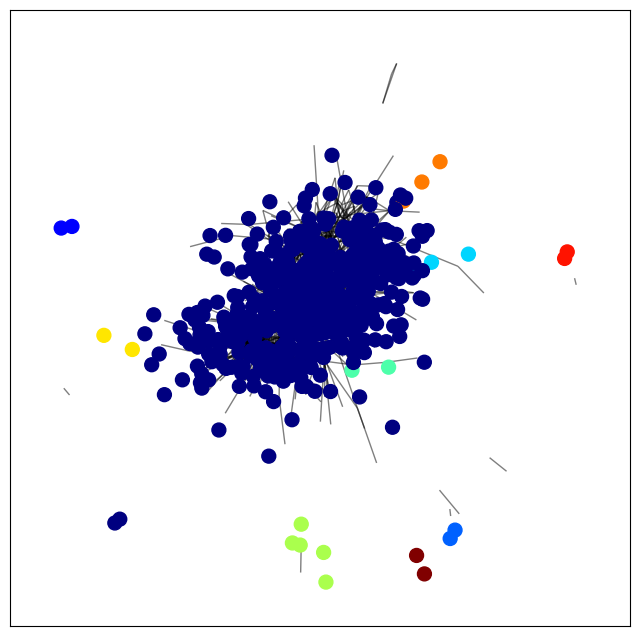

Community 0: [0, 188, 779, 5, 149, 237, 328, 364, 513, 598, 6, 632, 661, 708, 12, 111, 206, 563, 620, 643, 772, 13, 163, 196, 423, 534, 582, 14, 428, 16, 517, 20, 747, 793, 21, 64, 215, 229, 272, 329, 515, 556, 688, 770, 789, 811, 22, 25, 241, 274, 553, 616, 775, 29, 77, 225, 245, 343, 419, 447, 501, 566, 608, 615, 672, 701, 755, 30, 197, 252, 383, 576, 31, 257, 283, 448, 535, 813, 32, 33, 288, 500, 34, 718, 751, 35, 450, 480, 36, 39, 41, 425, 42, 53, 82, 310, 610, 656, 697, 721, 784, 43, 45, 432, 462, 47, 438, 48, 452, 52, 768, 223, 371, 546, 763, 54, 138, 56, 57, 88, 90, 136, 273, 344, 589, 58, 60, 200, 236, 238, 293, 299, 334, 345, 379, 417, 514, 573, 660, 798, 62, 240, 75, 104, 110, 144, 150, 165, 251, 295, 377, 402, 415, 446, 461, 538, 558, 569, 601, 619, 669, 681, 723, 741, 750, 774, 65, 66, 189, 313, 68, 70, 306, 623, 71, 728, 73, 74, 120, 76, 78, 79, 270, 81, 491, 84, 398, 85, 133, 170, 326, 336, 453, 560, 567, 86, 87, 327, 249, 418, 510, 633, 739, 92, 254, 98, 103, 753, 105, 1

In [ ]:
# Detect communities using spectral clustering
partition_md_spectral = detect_communities_spectral(G_md, 10)

communities_md_spectral = print_communities_spectral(partition_md_spectral)

modularity_md_spectral = compute_modularity_spectral(G_md, partition_md_spectral)
print(f"Modularity (Spectral): {modularity_md_spectral}")

conductances = compute_conductance(G_md, partition_md_spectral)
average_conductance_md_spectral = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Spectral): {average_conductance_md_spectral}")

### MD-Agreement subset

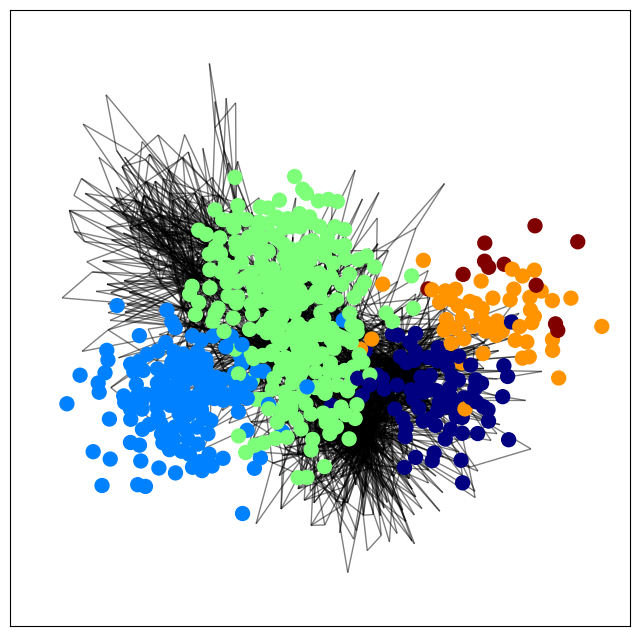

Community 2: [0, 65, 188, 260, 266, 546, 576, 721, 733, 739, 779, 814, 149, 582, 681, 791, 10, 47, 16, 20, 164, 246, 285, 517, 730, 655, 719, 747, 793, 64, 344, 425, 556, 811, 22, 81, 186, 760, 377, 34, 79, 90, 232, 390, 402, 500, 589, 704, 718, 751, 152, 162, 37, 768, 42, 82, 88, 371, 381, 424, 515, 573, 596, 697, 713, 774, 784, 785, 44, 60, 334, 511, 169, 297, 351, 438, 449, 466, 715, 49, 52, 205, 508, 53, 118, 153, 417, 526, 763, 456, 55, 56, 57, 86, 91, 136, 141, 340, 352, 379, 434, 509, 514, 557, 558, 669, 712, 58, 59, 142, 173, 200, 212, 238, 293, 418, 619, 638, 641, 656, 699, 723, 62, 240, 675, 75, 104, 134, 165, 295, 317, 369, 461, 609, 670, 750, 766, 777, 783, 799, 743, 72, 276, 74, 120, 420, 76, 288, 581, 80, 210, 144, 372, 354, 728, 610, 767, 166, 192, 349, 436, 459, 510, 518, 613, 633, 682, 732, 464, 693, 254, 94, 95, 663, 96, 265, 555, 99, 100, 102, 286, 376, 753, 105, 572, 769, 106, 568, 109, 453, 121, 135, 435, 642, 140, 220, 389, 400, 415, 491, 748, 147, 504, 282, 332, 

In [ ]:
# Detect communities using spectral clustering
partition_md_subset_spectral = detect_communities_spectral(G_md_subset, 5)

communities_md_subset_spectral = print_communities_spectral(partition_md_subset_spectral)

modularity_md_subset_spectral = compute_modularity_spectral(G_md_subset, partition_md_subset_spectral)
print(f"Modularity (Spectral): {modularity_md_subset_spectral}")

conductances = compute_conductance(G_md_subset, partition_md_subset_spectral)
average_conductance_md_subset_spectral = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Spectral): {average_conductance_md_subset_spectral}")

### Offensiveness Popquorn full dataset

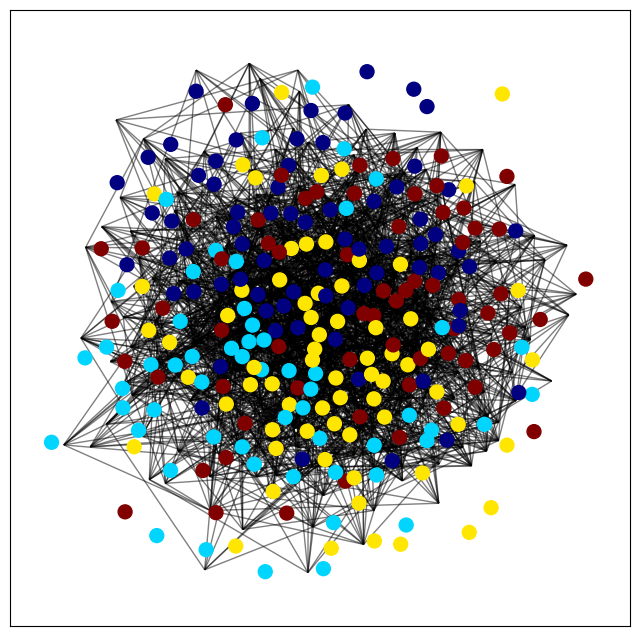

Community 3: [0, 35, 94, 112, 149, 209, 215, 219, 244, 251, 1, 56, 69, 154, 188, 230, 37, 98, 3, 121, 152, 162, 247, 258, 262, 115, 46, 129, 7, 45, 91, 161, 60, 194, 109, 14, 99, 116, 123, 201, 15, 50, 238, 19, 166, 187, 88, 65, 26, 77, 229, 28, 211, 235, 29, 227, 242, 30, 228, 130, 210, 204, 111, 261, 250, 207]
Community 0: [63, 81, 125, 127, 167, 74, 226, 49, 40, 5, 80, 97, 183, 231, 39, 135, 200, 203, 254, 41, 67, 73, 92, 136, 146, 170, 252, 106, 128, 171, 240, 10, 47, 62, 114, 138, 155, 158, 165, 11, 59, 90, 89, 191, 48, 75, 246, 33, 133, 139, 84, 20, 108, 126, 174, 142, 257, 259, 22, 177, 178, 25, 27, 232, 190, 206, 61, 185, 86, 225, 78, 96]
Community 2: [124, 148, 156, 168, 172, 182, 223, 239, 255, 160, 180, 198, 163, 66, 192, 221, 224, 248, 57, 6, 132, 151, 199, 32, 58, 87, 8, 53, 120, 181, 119, 159, 101, 256, 118, 100, 245, 79, 195, 196, 143, 202, 16, 31, 179, 17, 51, 147, 68, 85, 72, 23, 164, 197, 24, 93, 208, 144, 105, 176, 222, 213, 42, 44, 55, 110, 220, 214]
Community 1: [1

In [ ]:
# Detect communities using spectral clustering
partition_op_spectral = detect_communities_spectral(G_op, 4)

communities_op_spectral = print_communities_spectral(partition_op_spectral)

modularity_op_spectral = compute_modularity_spectral(G_op, partition_op_spectral)
print(f"Modularity (Spectral): {modularity_op_spectral}")

conductances = compute_conductance(G_op, partition_op_spectral)
average_conductance_op_spectral = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Spectral): {average_conductance_op_spectral}")

### Offensiveness Popquorn subset

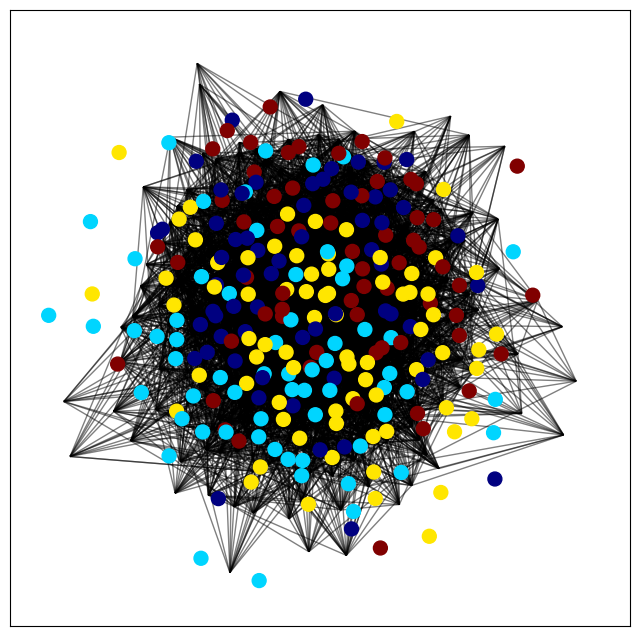

Community 3: [0, 43, 65, 81, 87, 98, 182, 209, 223, 244, 245, 251, 44, 60, 63, 85, 141, 157, 238, 64, 83, 236, 3, 45, 55, 68, 118, 126, 134, 160, 162, 163, 205, 207, 222, 259, 4, 70, 76, 97, 112, 174, 221, 120, 176, 35, 36, 200, 233, 84, 169, 165, 185, 12, 159, 261, 201, 17, 19, 152, 227, 24, 130, 25]
Community 2: [34, 48, 61, 62, 105, 146, 153, 180, 193, 196, 144, 186, 189, 206, 210, 46, 57, 106, 127, 166, 191, 28, 41, 47, 58, 99, 109, 137, 181, 248, 256, 93, 116, 6, 39, 49, 79, 96, 108, 115, 129, 132, 167, 168, 171, 190, 211, 237, 255, 131, 218, 240, 258, 128, 247, 9, 42, 88, 119, 10, 101, 199, 11, 51, 89, 133, 208, 13, 37, 125, 14, 246, 220, 110]
Community 1: [82, 94, 103, 135, 136, 138, 148, 172, 102, 139, 188, 204, 230, 2, 75, 92, 124, 143, 183, 213, 241, 242, 31, 107, 121, 177, 117, 140, 249, 32, 147, 228, 257, 53, 122, 164, 252, 262, 8, 71, 113, 203, 229, 235, 66, 54, 154, 215, 59, 202, 178, 15, 214, 18, 232, 22, 23, 156, 224, 29, 30, 100]
Community 0: [219, 1, 50, 69, 72, 111, 

In [ ]:
# Detect communities using spectral clustering
partition_op_subset_spectral = detect_communities_spectral(G_op_subset, 4)

communities_op_subset_spectral = print_communities_spectral(partition_op_subset_spectral)

modularity_op_subset_spectral = compute_modularity_spectral(G_op_subset, partition_op_subset_spectral)
print(f"Modularity (Spectral): {modularity_op_subset_spectral}")

conductances = compute_conductance(G_op_subset, partition_op_subset_spectral)
average_conductance_op_subset_spectral = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Spectral): {average_conductance_op_subset_spectral}")

### Comparison

In [ ]:
data = {
    'Dataset': ['Full Md', 'Full OP', 'Md Subset', 'OP Subset'],

    'Modularity (Louvain)': [modularity_md_louvain, modularity_op_louvain, modularity_md_subset_louvain, modularity_op_subset_louvain],
    'Conductance (Louvain)': [average_conductance_md_louvain, average_conductance_op_louvain, average_conductance_md_subset_louvain, average_conductance_op_subset_louvain],

    'Modularity (Leiden)': [modularity_md_leiden, modularity_op_leiden, modularity_md_subset_leiden, modularity_op_subset_leiden],
    'Conductance (Leiden)': [average_conductance_md_leiden, average_conductance_op_leiden, average_conductance_md_subset_leiden, average_conductance_op_subset_leiden],

    'Modularity (Spectral)': [modularity_md_spectral, modularity_op_spectral, modularity_md_subset_spectral, modularity_op_subset_spectral],
    'Conductance (Spectral)': [average_conductance_md_spectral, average_conductance_op_spectral, average_conductance_md_subset_spectral, average_conductance_op_subset_spectral],
}

df = pd.DataFrame(data)
df

Dataset  Modularity (Louvain)  Conductance (Louvain)  \
0    Full Md              0.592134               0.258618   
1    Full OP              0.246131               0.708632   
2  Md Subset              0.540413               0.200517   
3  OP Subset              0.134405               0.740685   

   Modularity (Leiden)  Conductance (Leiden)  Modularity (Spectral)  \
0             0.595415              0.108857               0.011810   
1             0.217473              0.684203               0.179530   
2             0.550331              0.268184               0.476911   
3             0.149420              0.650672               0.130482   

   Conductance (Spectral)  
0                0.000000  
1                0.569722  
2                0.240571  
3                0.620278

Choose MD-Agreement subset with Leiden for now (finalise after rerunning spectral) - reason also being equal communities. For comparison, choose Leiden full OP.


# Step 5: Save groups as datasets

In [ ]:
def assign_community_labels(data, communities):
    """Assign community labels to data."""
    data['community'] = None
    for community, users in communities.items():
        data.loc[data['user_id'].isin(users), 'community'] = community
    return data

def split_data_by_community(data, communities):
    data = assign_community_labels(data, communities)
    community_dfs = {community: data[data['community'] == community] for community in communities.keys()}
    return community_dfs

communities_md_subset = split_data_by_community(md_agreement_subset, communities_md_subset_leiden)

for community, df in communities_md_subset.items():
    df.to_csv(f"community_{community}_data_final_md.csv", index=False)

# 4. Combine all community DataFrames to have one with community labels and save it
combined_data_with_community_labels = pd.concat(communities_md_subset.values(), axis=0)
combined_data_with_community_labels.to_csv("combined_communities_data_final_md.csv", index=False)

In [ ]:
def assign_community_labels(data, communities):
    """Assign community labels to data."""
    data['community'] = None
    for community, users in communities.items():
        data.loc[data['user_id'].isin(users), 'community'] = community
    return data

def split_data_by_community(data, communities):
    data = assign_community_labels(data, communities)
    community_dfs = {community: data[data['community'] == community] for community in communities.keys()}
    return community_dfs

communities_md_subset = split_data_by_community(offensiveness_popquorn, communities_op_spectral)

for community, df in communities_md_subset.items():
    df.to_csv(f"community_{community}_data_final_op.csv", index=False)

combined_data_with_community_labels = pd.concat(communities_md_subset.values(), axis=0)
combined_data_with_community_labels.to_csv("combined_communities_data_final_op.csv", index=False)

Note for later: do some in group and within group analysis. Do some analysis with node attributes. Maybe worth also choose an OP one for reddit vs twitter comparison and training models on that too.